## Daily Code Workout Day 8(220505)
1. Monty Hall Problem
2. Covid Simulation
3. Covid Data Analysis
4. FFT TS Projection(<- Here!)

Data Source: https://finance.yahoo.com/quote/%5EGSPC/history/

#### 00. Packages Used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [11, 4]

In [2]:
df_o = pd.read_excel("./sp500_5y.xlsx")

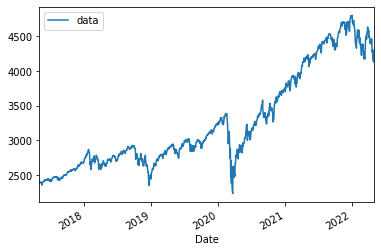

In [3]:
df = df_o[['Date', 'Adj Close**']].copy().set_index("Date").sort_index()
df.columns = ['data']
df.plot()
df_p = df.resample("W").mean().copy().dropna()
df_p = df_p.pct_change(52).dropna()

In [4]:
def ts_to_sines(df_o):
    df = df_o.copy().dropna()
    n = df.shape[0]
    fhat = np.fft.fft(df.T.values[0], n)
    PSD = fhat * np.conj(fhat) / n

    val = pd.DataFrame(PSD).reset_index()
    val['real'] = val[0].map(lambda x: x.real)
    val = val.head(int(val.shape[0]/2)).sort_values(by = "real", ascending = False)
    
    idx_dict = dict(zip(val['index'], [np.zeros(len(PSD)) for x in range(val.shape[0])]))
    for idx in list(idx_dict):
        idx_dict[idx][idx] = 1
    idx_dict = {k: [x.real for x in np.fft.ifft(fhat * idx_dict[k])] for k in list(idx_dict)}
    return(idx_dict)

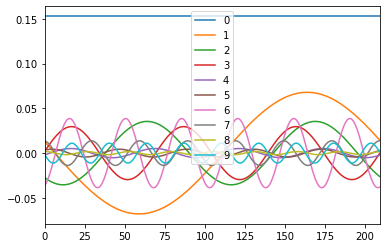

In [5]:
res_dict = ts_to_sines(df_p)
res_df = pd.concat([pd.DataFrame(res_dict[x]) for x in range(10)], axis = 1)
res_df.columns = [x for x in range(res_df.shape[1])]

res_df.plot()

In [6]:
def extend_sine(df_o, add_n = 52, proj_only = False):
    df = df_o.copy()[list(df_o)[:1]].dropna()
    col = list(df)[0]
    half = sorted([df[col].idxmin(), df[col].idxmax()])
    n = df.shape[0] + 52
    short_n = df[(df.index<=half[1])].shape[0]
    
    c_df = df[(df.index>=half[0]) & (df.index<=half[1])]
    c_df = pd.concat([c_df.iloc[1:].sort_index(ascending = False), c_df])
    if proj_only:
        c_df = c_df.iloc[1:].reset_index(drop = True)
        return(pd.concat([c_df] * (int( (n - short_n)/c_df.shape[0]) + 1)).head(n).reset_index(drop = True))
    else:
        c_df = c_df.iloc[1:].reset_index(drop = True).rename(columns = {col:str(col)+"_proj"})
        return(pd.concat([df[(df.index<=half[1])].reset_index(drop = True),
                          pd.concat([c_df] * (int( (n - short_n)/c_df.shape[0]) + 1)).head(n).reset_index(drop = True)]))

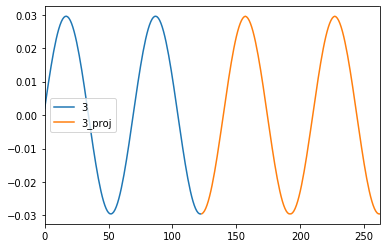

In [8]:
extend_sine(res_df.copy()[[3]]).reset_index(drop = True).plot()